In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, List, Dict

# For nice inline plots
%matplotlib inline
plt.style.use('default')

print("Setup complete!")

Setup complete!


In [6]:
# Your CSV path
CSV_PATH = "/DATA/pyare/Routine/LLM/Reasoning/LLMs-from-scratch-pyare/chapter-2-tokenization/car_pcloud.csv"

# Load the data
df = pd.read_csv(CSV_PATH)

print(f"Loaded {len(df)} points")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Loaded 24949 points

Columns: ['x', 'y', 'z', 'intensity', 'gps_time', 'label', 'global_id']

First 5 rows:


,x,y,z,intensity,gps_time,label,global_id
0,746058.267407,2.574345e+06,451.363647,6682,4489.983887,30,708010003
1,746058.311230,2.574345e+06,451.204956,20560,4489.983887,30,708010003
2,746058.355298,2.574345e+06,451.051636,6682,4489.983887,30,708010003
3,746058.447095,2.574345e+06,452.127258,4626,4491.277344,30,708010003
4,746058.274121,2.574345e+06,450.950653,5397,4491.375488,30,708010003


In [7]:
# Extract coordinates
coords_raw = df[['x', 'y', 'z']].values

print("Raw coordinate ranges:")
print(f"  X: [{coords_raw[:, 0].min():.2f}, {coords_raw[:, 0].max():.2f}]")
print(f"  Y: [{coords_raw[:, 1].min():.2f}, {coords_raw[:, 1].max():.2f}]")
print(f"  Z: [{coords_raw[:, 2].min():.2f}, {coords_raw[:, 2].max():.2f}]")

Raw coordinate ranges:
  X: [746058.00, 746059.67]
  Y: [2574344.47, 2574348.48]
  Z: [450.58, 452.23]


In [8]:
# Normalize to start from origin (0, 0, 0)
coords = coords_raw - coords_raw.min(axis=0)

print(f"\nNormalized coordinate ranges:")
print(f"  X: [{coords[:, 0].min():.2f}, {coords[:, 0].max():.2f}]")
print(f"  Y: [{coords[:, 1].min():.2f}, {coords[:, 1].max():.2f}]")
print(f"  Z: [{coords[:, 2].min():.2f}, {coords[:, 2].max():.2f}]")


Normalized coordinate ranges:
  X: [0.00, 1.67]
  Y: [0.00, 4.01]
  Z: [0.00, 1.65]


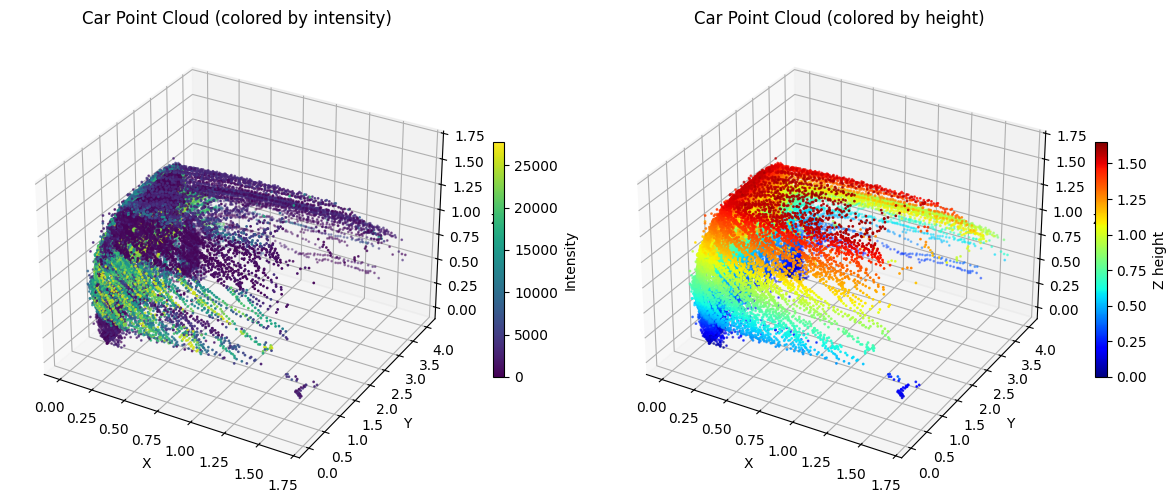


Total points: 24949


In [9]:
# Visualize the original point cloud
fig = plt.figure(figsize=(12, 5))

# Colored by intensity
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
                       c=df['intensity'].values, cmap='viridis', s=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Car Point Cloud (colored by intensity)')
plt.colorbar(scatter1, ax=ax1, shrink=0.5, label='Intensity')

# Colored by Z (height)
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
                       c=coords[:, 2], cmap='jet', s=1)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Car Point Cloud (colored by height)')
plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='Z height')

plt.tight_layout()
plt.show()

print(f"\nTotal points: {len(coords)}")

---
## Step 2: Grid Quantization

**Purpose:** Convert continuous 3D coordinates into discrete grid coordinates.

This is essential because:
1. Morton/Hilbert codes work on integers
2. It acts as a form of voxelization
3. Controls the resolution of the serialization

```
Continuous (0.15, 0.27, 0.43) → Grid (1, 2, 4) with grid_size=0.1
```

In [10]:
def quantize_to_grid(coords: np.ndarray, grid_size: float = 0.1) -> np.ndarray:
    """
    Convert continuous 3D coordinates to discrete grid coordinates.
    
    Args:
        coords: (N, 3) array of [x, y, z] coordinates
        grid_size: Size of each voxel (e.g., 0.1 = 10cm)
    
    Returns:
        grid_coords: (N, 3) array of integer grid coordinates
    """
    grid_coords = np.floor(coords / grid_size).astype(np.int64)
    return grid_coords

    
# Choose grid size (experiment with different values!)
GRID_SIZE = 0.05  # 5cm voxels

grid_coords = quantize_to_grid(coords, GRID_SIZE)

print(f"Grid size: {GRID_SIZE}m ({GRID_SIZE*100}cm)")
print(f"\nGrid coordinate ranges:")
print(f"  X: [{grid_coords[:, 0].min()}, {grid_coords[:, 0].max()}] ({grid_coords[:, 0].max() - grid_coords[:, 0].min() + 1} cells)")
print(f"  Y: [{grid_coords[:, 1].min()}, {grid_coords[:, 1].max()}] ({grid_coords[:, 1].max() - grid_coords[:, 1].min() + 1} cells)")
print(f"  Z: [{grid_coords[:, 2].min()}, {grid_coords[:, 2].max()}] ({grid_coords[:, 2].max() - grid_coords[:, 2].min() + 1} cells)")

# Count unique grid cells
unique_cells = len(np.unique(grid_coords, axis=0))
print(f"\nUnique grid cells: {unique_cells} (out of {len(coords)} points)")
print(f"Average points per cell: {len(coords) / unique_cells:.2f}")


Grid size: 0.05m (5.0cm)

Grid coordinate ranges:
  X: [0, 33] (34 cells)
  Y: [0, 80] (81 cells)
  Z: [0, 33] (34 cells)

Unique grid cells: 6485 (out of 24949 points)
Average points per cell: 3.85


In [11]:
# Let's look at a few example points
print("Example: Continuous → Grid conversion")
print("=" * 60)
print(f"{'Point':<8} {'Continuous (x,y,z)':<30} {'Grid (gx,gy,gz)':<20}")
print("-" * 60)

for i in [0, 1, 2, 100, 500, len(coords)-1]:
    cx, cy, cz = coords[i]
    gx, gy, gz = grid_coords[i]
    print(f"P{i:<6} ({cx:>7.3f}, {cy:>7.3f}, {cz:>7.3f})    ({gx:>3}, {gy:>3}, {gz:>3})")

Example: Continuous → Grid conversion
Point    Continuous (x,y,z)             Grid (gx,gy,gz)     
------------------------------------------------------------
P0      (  0.268,   0.193,   0.789)    (  5,   3,  15)
P1      (  0.312,   0.157,   0.630)    (  6,   3,  12)
P2      (  0.356,   0.183,   0.477)    (  7,   3,   9)
P100    (  0.184,   0.222,   1.031)    (  3,   4,  20)
P500    (  0.403,   0.447,   1.449)    (  8,   8,  28)
P24948  (  1.666,   3.723,   0.653)    ( 33,  74,  13)


In [12]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from collections import Counter

In [13]:
def draw_voxel_wireframe(ax, origin, size, color='blue', alpha=0.3):
    """
    Draw a single voxel as a wireframe cube.
    
    Args:
        ax: matplotlib 3D axis
        origin: (x, y, z) corner of the voxel
        size: size of the voxel (grid_size)
        color: face color
        alpha: transparency
    """
    x, y, z = origin
    s = size
    
    # Define the 8 vertices of the cube
    vertices = [
        [x, y, z], [x+s, y, z], [x+s, y+s, z], [x, y+s, z],      # bottom face
        [x, y, z+s], [x+s, y, z+s], [x+s, y+s, z+s], [x, y+s, z+s]  # top face
    ]
    
    # Define the 6 faces using vertices
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # front
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # back
        [vertices[0], vertices[3], vertices[7], vertices[4]],  # left
        [vertices[1], vertices[2], vertices[6], vertices[5]]   # right
    ]
    
    ax.add_collection3d(Poly3DCollection(faces, alpha=alpha, 
                                          facecolor=color, 
                                          edgecolor='black', 
                                          linewidth=0.5))


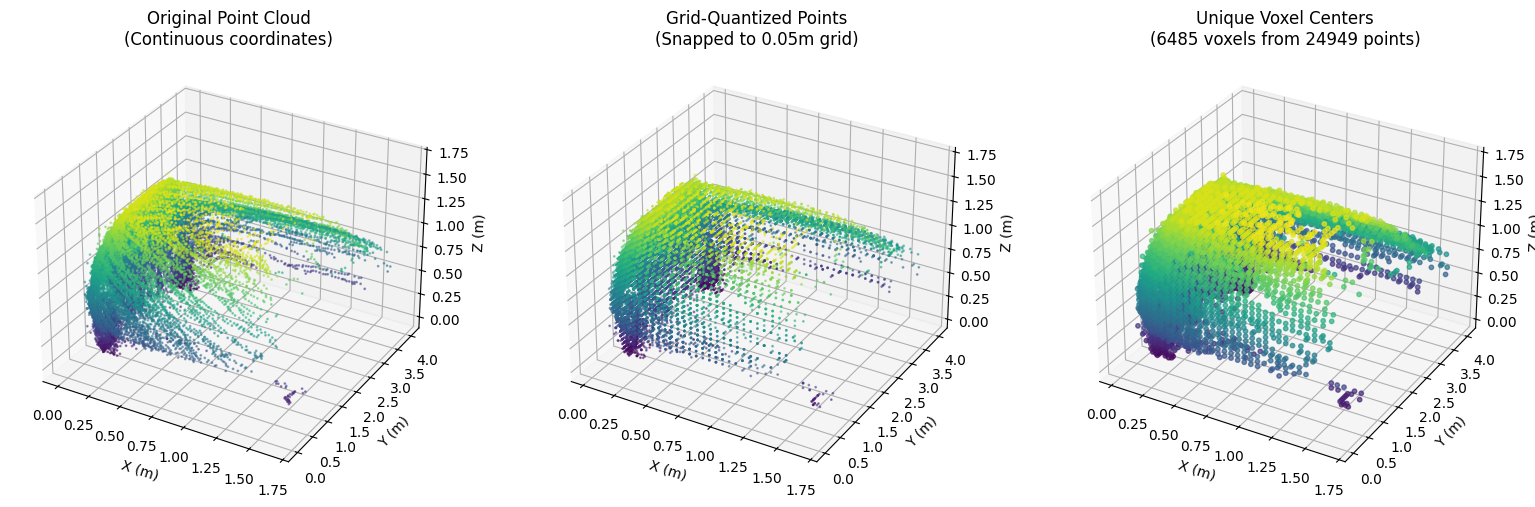

In [14]:
fig = plt.figure(figsize=(16, 5))

# 1. Original points
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
           c=coords[:, 2], cmap='viridis', s=1, alpha=0.5)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('Original Point Cloud\n(Continuous coordinates)')

# 2. Grid-snapped points (center of each voxel)
grid_centers = (grid_coords + 0.5) * GRID_SIZE
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(grid_centers[:, 0], grid_centers[:, 1], grid_centers[:, 2], 
           c=grid_coords[:, 2], cmap='viridis', s=1, alpha=0.5)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')
ax2.set_title(f'Grid-Quantized Points\n(Snapped to {GRID_SIZE}m grid)')

# 3. Unique voxel centers only (one point per voxel)
unique_grid, unique_indices = np.unique(grid_coords, axis=0, return_index=True)
unique_centers = (unique_grid + 0.5) * GRID_SIZE

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(unique_centers[:, 0], unique_centers[:, 1], unique_centers[:, 2], 
           c=unique_grid[:, 2], cmap='viridis', s=10, alpha=0.7)
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_zlabel('Z (m)')
ax3.set_title(f'Unique Voxel Centers\n({len(unique_grid)} voxels from {len(coords)} points)')

plt.tight_layout()
plt.show()


Region contains 0 points
Drawing 0 voxels...


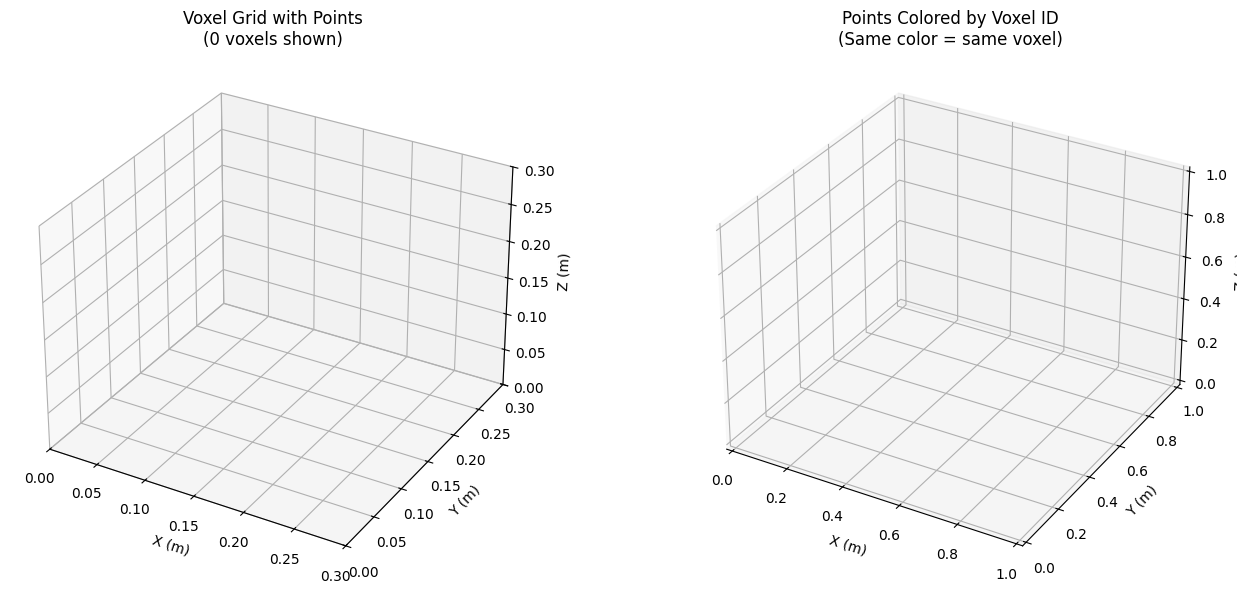

In [15]:
# Select a small region to visualize voxels clearly
x_range = (0, 6)  # First 6 grid cells in X
y_range = (0, 6)  # First 6 grid cells in Y
z_range = (0, 6)  # First 6 grid cells in Z

# Filter points in this region
mask = ((grid_coords[:, 0] >= x_range[0]) & (grid_coords[:, 0] < x_range[1]) &
        (grid_coords[:, 1] >= y_range[0]) & (grid_coords[:, 1] < y_range[1]) &
        (grid_coords[:, 2] >= z_range[0]) & (grid_coords[:, 2] < z_range[1]))

region_coords = coords[mask]
region_grid = grid_coords[mask]

print(f"Region contains {len(region_coords)} points")

fig = plt.figure(figsize=(14, 6))

# Left: Points with voxel wireframes
ax1 = fig.add_subplot(121, projection='3d')

# Get unique voxels in this region
unique_voxels_region = np.unique(region_grid, axis=0)
colors_voxel = plt.cm.Set3(np.linspace(0, 1, min(len(unique_voxels_region), 20)))

print(f"Drawing {len(unique_voxels_region)} voxels...")

# Draw occupied voxels as wireframes
for i, voxel in enumerate(unique_voxels_region[:30]):  # Limit for clarity
    origin = voxel * GRID_SIZE
    draw_voxel_wireframe(ax1, origin, GRID_SIZE, 
                        color=colors_voxel[i % len(colors_voxel)], alpha=0.2)

# Draw points
ax1.scatter(region_coords[:, 0], region_coords[:, 1], region_coords[:, 2],
           c='red', s=10, alpha=0.8, label='Points')

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title(f'Voxel Grid with Points\n({len(unique_voxels_region)} voxels shown)')
ax1.set_xlim([x_range[0]*GRID_SIZE, x_range[1]*GRID_SIZE])
ax1.set_ylim([y_range[0]*GRID_SIZE, y_range[1]*GRID_SIZE])
ax1.set_zlim([z_range[0]*GRID_SIZE, z_range[1]*GRID_SIZE])

# Right: Points colored by their voxel
ax2 = fig.add_subplot(122, projection='3d')

# Create unique voxel ID for coloring
voxel_ids = region_grid[:, 0] * 10000 + region_grid[:, 1] * 100 + region_grid[:, 2]
unique_ids = np.unique(voxel_ids)
id_to_color = {uid: i for i, uid in enumerate(unique_ids)}
point_colors = [id_to_color[vid] for vid in voxel_ids]

ax2.scatter(region_coords[:, 0], region_coords[:, 1], region_coords[:, 2],
           c=point_colors, cmap='tab20', s=15, alpha=0.8)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')
ax2.set_title(f'Points Colored by Voxel ID\n(Same color = same voxel)')

plt.tight_layout()
plt.show()

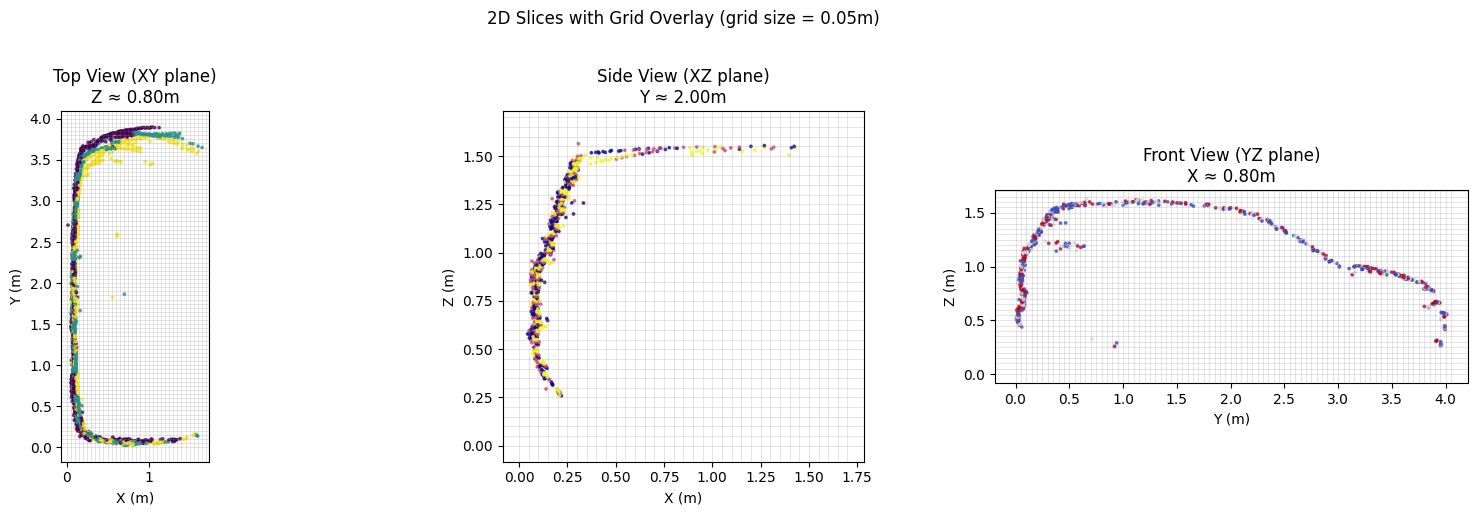

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# XY slice (top-down view) at middle Z level
z_mid = grid_coords[:, 2].max() // 2
mask_xy = (grid_coords[:, 2] >= z_mid - 1) & (grid_coords[:, 2] <= z_mid + 1)

ax1 = axes[0]
if mask_xy.sum() > 0:
    ax1.scatter(coords[mask_xy, 0], coords[mask_xy, 1], 
               c=grid_coords[mask_xy, 2], cmap='viridis', s=3, alpha=0.7)
    
# Draw grid lines
for i in range(grid_coords[:, 0].max() + 2):
    ax1.axvline(x=i * GRID_SIZE, color='gray', linewidth=0.5, alpha=0.3)
for j in range(grid_coords[:, 1].max() + 2):
    ax1.axhline(y=j * GRID_SIZE, color='gray', linewidth=0.5, alpha=0.3)

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title(f'Top View (XY plane)\nZ ≈ {z_mid * GRID_SIZE:.2f}m')
ax1.set_aspect('equal')

# XZ slice (side view) at middle Y level
y_mid = grid_coords[:, 1].max() // 2
mask_xz = (grid_coords[:, 1] >= y_mid - 1) & (grid_coords[:, 1] <= y_mid + 1)

ax2 = axes[1]
if mask_xz.sum() > 0:
    ax2.scatter(coords[mask_xz, 0], coords[mask_xz, 2], 
               c=grid_coords[mask_xz, 1], cmap='plasma', s=3, alpha=0.7)

# Draw grid lines
for i in range(grid_coords[:, 0].max() + 2):
    ax2.axvline(x=i * GRID_SIZE, color='gray', linewidth=0.5, alpha=0.3)
for k in range(grid_coords[:, 2].max() + 2):
    ax2.axhline(y=k * GRID_SIZE, color='gray', linewidth=0.5, alpha=0.3)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Z (m)')
ax2.set_title(f'Side View (XZ plane)\nY ≈ {y_mid * GRID_SIZE:.2f}m')
ax2.set_aspect('equal')

# YZ slice (front view) at middle X level
x_mid = grid_coords[:, 0].max() // 2
mask_yz = (grid_coords[:, 0] >= x_mid - 1) & (grid_coords[:, 0] <= x_mid + 1)

ax3 = axes[2]
if mask_yz.sum() > 0:
    ax3.scatter(coords[mask_yz, 1], coords[mask_yz, 2], 
               c=grid_coords[mask_yz, 0], cmap='coolwarm', s=3, alpha=0.7)

# Draw grid lines
for j in range(grid_coords[:, 1].max() + 2):
    ax3.axvline(x=j * GRID_SIZE, color='gray', linewidth=0.5, alpha=0.3)
for k in range(grid_coords[:, 2].max() + 2):
    ax3.axhline(y=k * GRID_SIZE, color='gray', linewidth=0.5, alpha=0.3)

ax3.set_xlabel('Y (m)')
ax3.set_ylabel('Z (m)')
ax3.set_title(f'Front View (YZ plane)\nX ≈ {x_mid * GRID_SIZE:.2f}m')
ax3.set_aspect('equal')

plt.suptitle(f'2D Slices with Grid Overlay (grid size = {GRID_SIZE}m)', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


Total unique voxels: 6485
Points per voxel - Min: 1, Max: 21, Mean: 3.85


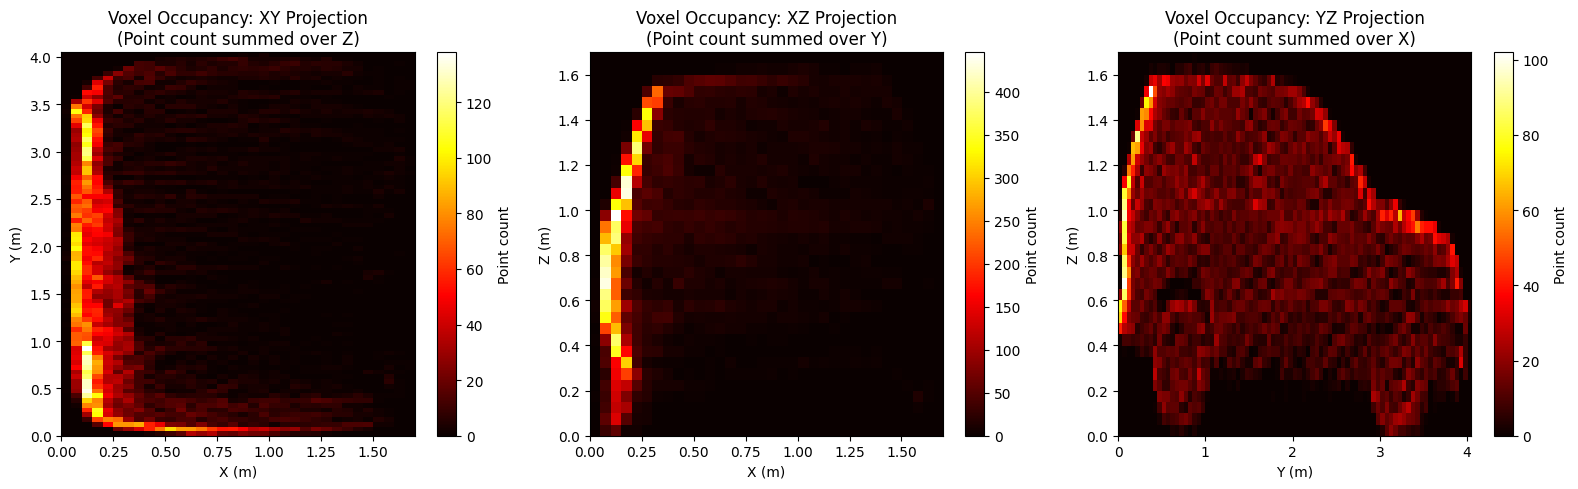

In [17]:
# Count points per voxel
voxel_tuples = [tuple(g) for g in grid_coords]
voxel_counts = Counter(voxel_tuples)

print(f"Total unique voxels: {len(voxel_counts)}")
print(f"Points per voxel - Min: {min(voxel_counts.values())}, Max: {max(voxel_counts.values())}, Mean: {np.mean(list(voxel_counts.values())):.2f}")

# Create occupancy arrays
x_max = grid_coords[:, 0].max() + 1
y_max = grid_coords[:, 1].max() + 1
z_max = grid_coords[:, 2].max() + 1

xy_occupancy = np.zeros((x_max, y_max))
xz_occupancy = np.zeros((x_max, z_max))
yz_occupancy = np.zeros((y_max, z_max))

for (x, y, z), count in voxel_counts.items():
    xy_occupancy[x, y] += count
    xz_occupancy[x, z] += count
    yz_occupancy[y, z] += count

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# XY projection heatmap
im1 = axes[0].imshow(xy_occupancy.T, origin='lower', cmap='hot', aspect='auto',
                     extent=[0, x_max*GRID_SIZE, 0, y_max*GRID_SIZE])
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_title('Voxel Occupancy: XY Projection\n(Point count summed over Z)')
plt.colorbar(im1, ax=axes[0], label='Point count')

# XZ projection heatmap
im2 = axes[1].imshow(xz_occupancy.T, origin='lower', cmap='hot', aspect='auto',
                     extent=[0, x_max*GRID_SIZE, 0, z_max*GRID_SIZE])
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Z (m)')
axes[1].set_title('Voxel Occupancy: XZ Projection\n(Point count summed over Y)')
plt.colorbar(im2, ax=axes[1], label='Point count')

# YZ projection heatmap
im3 = axes[2].imshow(yz_occupancy.T, origin='lower', cmap='hot', aspect='auto',
                     extent=[0, y_max*GRID_SIZE, 0, z_max*GRID_SIZE])
axes[2].set_xlabel('Y (m)')
axes[2].set_ylabel('Z (m)')
axes[2].set_title('Voxel Occupancy: YZ Projection\n(Point count summed over X)')
plt.colorbar(im3, ax=axes[2], label='Point count')

plt.tight_layout()
plt.show()


Voxel with most points: (np.int64(1), np.int64(35), np.int64(12)) (21 points)


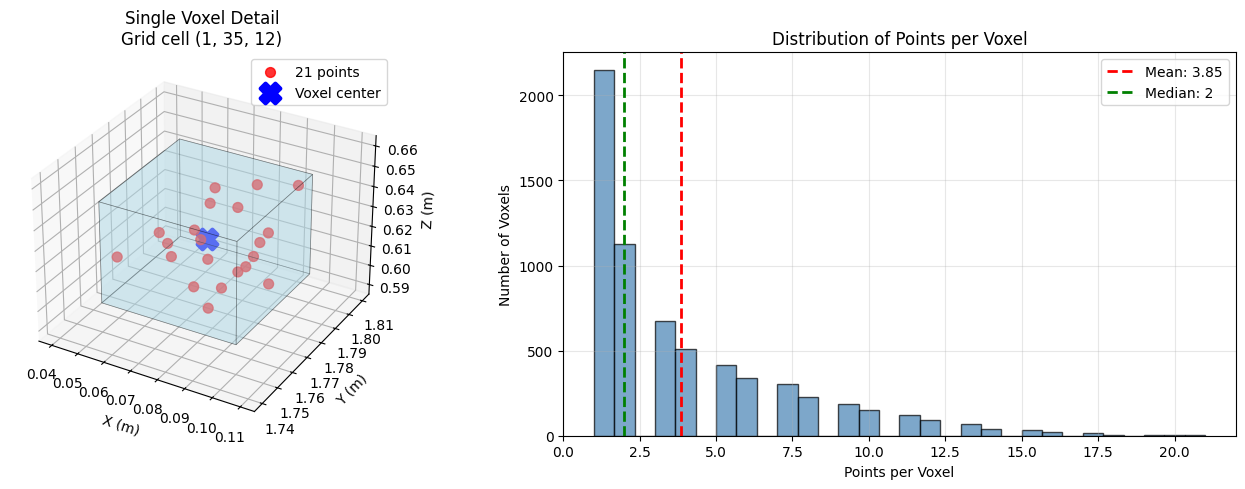

In [18]:
# Find voxel with most points
voxel_with_max_points = max(voxel_counts.keys(), key=lambda v: voxel_counts[v])
max_count = voxel_counts[voxel_with_max_points]

print(f"Voxel with most points: {voxel_with_max_points} ({max_count} points)")

# Get points in this voxel
vx, vy, vz = voxel_with_max_points
mask_single = ((grid_coords[:, 0] == vx) & 
               (grid_coords[:, 1] == vy) & 
               (grid_coords[:, 2] == vz))
single_voxel_points = coords[mask_single]

fig = plt.figure(figsize=(14, 5))

# Left: 3D view of single voxel with points
ax1 = fig.add_subplot(121, projection='3d')

# Draw the voxel box
origin = np.array([vx, vy, vz]) * GRID_SIZE
draw_voxel_wireframe(ax1, origin, GRID_SIZE, color='lightblue', alpha=0.3)

# Draw points inside the voxel
ax1.scatter(single_voxel_points[:, 0], single_voxel_points[:, 1], single_voxel_points[:, 2],
           c='red', s=50, alpha=0.8, label=f'{max_count} points')

# Draw voxel center
center = (np.array([vx, vy, vz]) + 0.5) * GRID_SIZE
ax1.scatter(*center, c='blue', s=200, marker='X', linewidths=3, label='Voxel center')

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title(f'Single Voxel Detail\nGrid cell ({vx}, {vy}, {vz})')
ax1.legend()

# Set tight bounds around this voxel
margin = GRID_SIZE * 0.3
ax1.set_xlim([origin[0] - margin, origin[0] + GRID_SIZE + margin])
ax1.set_ylim([origin[1] - margin, origin[1] + GRID_SIZE + margin])
ax1.set_zlim([origin[2] - margin, origin[2] + GRID_SIZE + margin])

# Right: Histogram of points per voxel
ax2 = fig.add_subplot(122)
counts = list(voxel_counts.values())
ax2.hist(counts, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=np.mean(counts), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(counts):.2f}')
ax2.axvline(x=np.median(counts), color='green', linestyle='--', linewidth=2,
            label=f'Median: {np.median(counts):.0f}')
ax2.set_xlabel('Points per Voxel')
ax2.set_ylabel('Number of Voxels')
ax2.set_title('Distribution of Points per Voxel')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


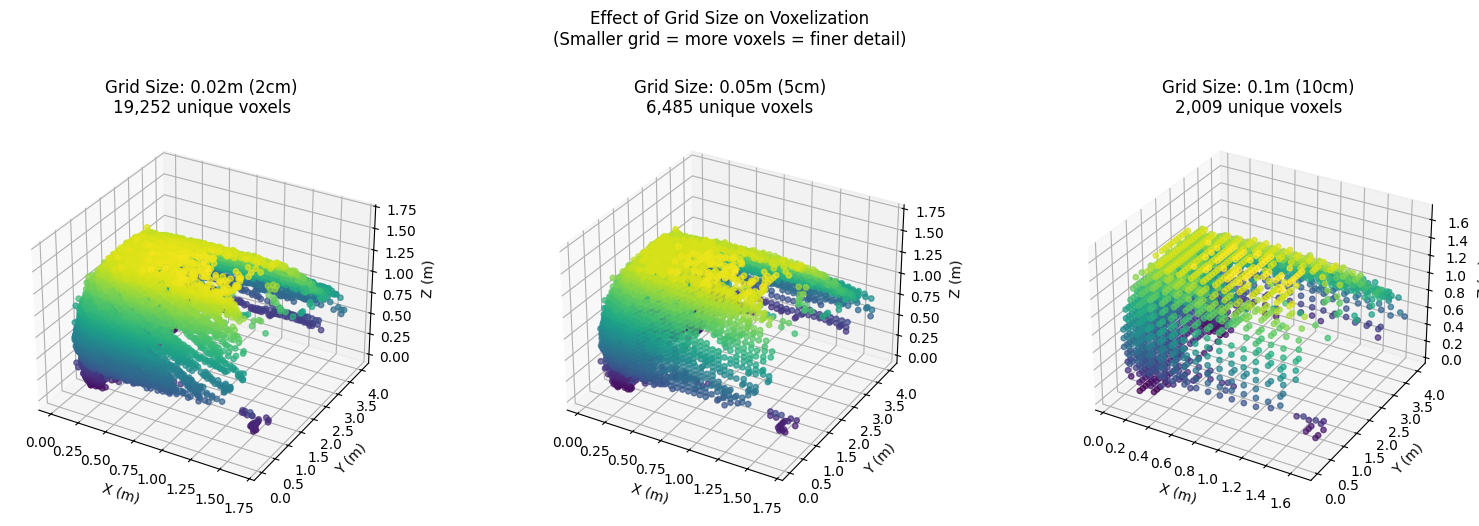


Grid size comparison:
  0.02m (2cm): 19,252 voxels, 1.3 pts/voxel avg
  0.05m (5cm): 6,485 voxels, 3.8 pts/voxel avg
  0.1m (10cm): 2,009 voxels, 12.4 pts/voxel avg


In [19]:
fig = plt.figure(figsize=(16, 5))

grid_sizes = [0.02, 0.05, 0.1]  # 2cm, 5cm, 10cm

for idx, gs in enumerate(grid_sizes):
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
    
    gc = quantize_to_grid(coords, gs)
    unique_gc = np.unique(gc, axis=0)
    unique_centers = (unique_gc + 0.5) * gs
    
    # Color by height
    ax.scatter(unique_centers[:, 0], unique_centers[:, 1], unique_centers[:, 2],
              c=unique_gc[:, 2], cmap='viridis', s=15, alpha=0.7)
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(f'Grid Size: {gs}m ({gs*100:.0f}cm)\n{len(unique_gc):,} unique voxels')

plt.suptitle('Effect of Grid Size on Voxelization\n(Smaller grid = more voxels = finer detail)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print("\nGrid size comparison:")
for gs in grid_sizes:
    gc = quantize_to_grid(coords, gs)
    unique_gc = np.unique(gc, axis=0)
    print(f"  {gs}m ({gs*100:.0f}cm): {len(unique_gc):,} voxels, {len(coords)/len(unique_gc):.1f} pts/voxel avg")
